<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/VAE_HSC_bands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [59]:
!ls '/content/drive/My Drive/EMILES'

SB_10_v11_BASTI_baseFe_KU.fits	SB_2_v11_BASTI_baseFe_KU.fits  SB_6_v11_BASTI_baseFe_KU.fits
SB_11_v11_BASTI_baseFe_KU.fits	SB_3_v11_BASTI_baseFe_KU.fits  SB_7_v11_BASTI_baseFe_KU.fits
SB_12_v11_BASTI_baseFe_KU.fits	SB_4_v11_BASTI_baseFe_KU.fits  SB_8_v11_BASTI_baseFe_KU.fits
SB_1_v11_BASTI_baseFe_KU.fits	SB_5_v11_BASTI_baseFe_KU.fits  SB_9_v11_BASTI_baseFe_KU.fits


In [60]:
import requests

def fetch_filter_data(filters):
    filter_dict = {}

    for name, url in filters:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.text.splitlines()
            wavelength, transmission = [], []

            for line in data:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        wavelength.append(float(parts[0]))
                        transmission.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that cannot be converted

            filter_dict[name] = {
                "wl": wavelength,
                "tr": transmission
            }
        else:
            print(f"Failed to fetch data for {name}")

    return filter_dict

filters = [['HSCg', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.g_filter'],
           ['HSCr', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.r_filter'],
           ['HSCi', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.i_filter'],
           ['HSCz', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.z_filter'],
           ['HSCY', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.Y_filter']]

filter_data = fetch_filter_data(filters)


In [61]:
import os
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

spec_points = 100
spec_range = (3900, 10200)

def bin_spectrum(spec, wl, spec_range, spec_points):
    min_wl, max_wl = spec_range
    bins = np.linspace(min_wl, max_wl, spec_points + 1)
    mean_values = []
    wl_values = []

    for i in range(len(bins) - 1):
        bin_mask = (wl >= bins[i]) & (wl < bins[i+1])
        bin_data = spec[bin_mask]
        mean_values.append(bin_data.mean() if bin_data.size > 0 else (bins[i] + bins[i+1]) / 2)
        wl_values.append(0.5*(bins[i] + bins[i+1]))
    return np.array(mean_values), np.array(wl_values)


def get_waves(hdr):
     waves = hdr['CRVAL1'] - (hdr['CRPIX1']-1.0)*hdr['CDELT1'] + ( np.arange(0., hdr['NAXIS1']) ) * hdr['CDELT1']
     ran = [waves[0], waves[-1]]
     return waves



def read_fits_files(directory):
    # Define the file pattern to match
    file_pattern = os.path.join(directory, "SB_?_v11_BASTI_baseFe_KU.fits")
    fits_files = glob.glob(file_pattern)

    all_spectra = []
    all_params = []

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            spectra = hdul[0].data  # Extracting spectral data
            params = hdul[1].data  # Extracting table data
            all_spectra.extend(spectra)
            all_params.append(np.array([tuple(row) for row in params]))  # Ensure structured array consistency

    # Stack spectra along a new axis if necessary (e.g., assuming same dimensions)
    stacked_spectra = np.array(all_spectra)  # Convert list to numpy array

    # Convert list of structured arrays into a single structured array
    structured_params = np.concatenate(all_params) if all_params else None

    # Create an Astropy Table
    result_table = Table(rows=structured_params, names=params.names)

    wl = get_waves(hdul[0].header)
    return stacked_spectra, result_table, wl

# Example usage
directory = "/content/drive/My Drive/EMILES/"  # Change to the directory containing your FITS files
spectra, param_table, wl = read_fits_files(directory)


 AGE   AGEBOL MGAL MSTARS MWD MBHNS MSUB    ZSTARS       ZBOL   
------ ------ ---- ------ --- ----- ---- ----------- -----------
1000.0 1000.0  1.0    1.0 0.0   0.0  0.0 0.022963073 0.022963073


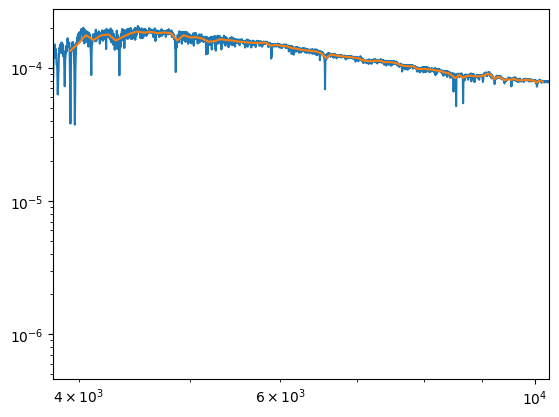

In [62]:
age = 1000
met = 0.02
da = np.abs(param_table['AGE'] - age)
dm = np.abs(param_table['ZSTARS'] - met)
idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]
print(param_table[idx])
spec = spectra[idx][0]

speclr, wllr = bin_spectrum(spec, wl, spec_range, spec_points)

plt.plot(wl, spec)
plt.plot(wllr, speclr)
plt.xlim(3800, 10300)
plt.xscale('log')
plt.yscale('log')


def calc_spec(spectra, param_table, wl, age = 1000, met = 0.02, z=0.0):
    da = np.abs(param_table['AGE'] - age)
    dm = np.abs(param_table['ZSTARS']/met - 1)
    idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]
    spec = spectra[idx][0]
    return (spec, wl*(1 + z))

In [63]:
def download_filter_curve(url):
    """Download and parse the filter transmission curve from a given URL."""
    response = requests.get(url)
    response.raise_for_status()
    data = np.loadtxt(response.iter_lines())
    return data[:, 0], data[:, 1]  # wavelengths, transmissions

def calculate_flux_and_mag(spectra_list, wavelengths_list, filters):
    """Calculate the flux and AB magnitude for multiple spectra and filters."""
    all_results = []
    all_speclr = []
    all_wllr = []

    for spectra, wavelengths in zip(spectra_list, wavelengths_list):
        results = []
        speclr, wllr = bin_spectrum(spectra, wavelengths, spec_range, spec_points)
        for filter_name, filter_url in filters:
            #filter_wavelengths, transmissions = download_filter_curve(filter_url)
            fd = filter_data[filter_name]
            filter_wavelengths, transmissions = fd['wl'], fd['tr']
            # Interpolate spectra onto the filter transmission wavelengths
            interp_flux = interp1d(wavelengths, spectra, kind='linear', fill_value=0, bounds_error=False)
            flux_interp = interp_flux(filter_wavelengths)

            # Calculate total flux (assuming simple integration)
            total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
            total_flux /= np.trapz(transmissions, filter_wavelengths)
            # Calculate AB magnitude
            if total_flux > 0:
                ab_magnitude = -2.5 * np.log10(total_flux) - 48.6  # AB mag formula
            else:
                ab_magnitude = np.inf  # Undefined magnitude for zero flux

            results.append([filter_name, total_flux, ab_magnitude])

        all_results.append(results)
        all_speclr.append(speclr)
        all_wllr.append(wllr)

    return all_results, [all_speclr, all_wllr]


filters = [['HSCg', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.g_filter'],
           ['HSCr', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.r_filter'],
           ['HSCi', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.i_filter'],
           ['HSCz', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.z_filter'],
           ['HSCY', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.Y_filter']]

spectra_list = []
wavelengths_list = []

z_vals = np.arange(0, 1, 0.05)
age_vals = np.arange(1000, 13000, 500, dtype=np.float64)
metdex_vals = [0, -0.3, -0.5]
param_list = []

for i,z in enumerate(z_vals):
    for j,age in enumerate(age_vals):
        for k,metdex in enumerate(metdex_vals):
            gen = calc_spec(spectra, param_table, wl, age = age, met = 0.02*10**metdex, z=z)
            spectra_list.append(gen[0])
            wavelengths_list.append(gen[1])
            param_list.append([z, age, metdex])  # Store the corresponding parameters


print(len(spectra_list))
print(len(wavelengths_list))
mags, lr = calculate_flux_and_mag(spectra_list, wavelengths_list, filters)

output_array = [[[entry[1] for entry in mag_entry], params, speclr] for mag_entry, params, speclr in zip(mags, param_list, lr[0])]

1440
1440


<ipython-input-63-668d168800f2>:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
<ipython-input-63-668d168800f2>:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux /= np.trapz(transmissions, filter_wavelengths)


In [72]:

output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(len(output_array))

N_smpl = 80  # Number of realizations per entry

# Create new array with perturbations
dataset_rnd = []

for flux_list, params, lr in output_array:
    for _ in range(N_smpl):
        perturbed_flux = [val + 0.1 * np.random.uniform(0, 1) * val for val in flux_list]  # Add perturbation
        dataset_rnd.append([perturbed_flux, params, lr])  # Duplicate params as required


integrals = 1e5 * np.array([entry[0] for entry in dataset_rnd])  # 2D array of flux values
params = np.array([entry[1] for entry in dataset_rnd])  # 2D array of corresponding parameters
params[:, 1] /= 1e4
spectra = np.array([entry[2] for entry in dataset_rnd])  # 2D array of corresponding parameters
spectra = 1e5 * np.array(spectra)


1440


In [90]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt



class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()

In [91]:
class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [95]:
spvae = SpectraVAE(100, 16, beta=0.00001)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - kl_loss: 81984.2578 - loss: 0.8910 - reconstruction_loss: 0.0711 - val_kl_loss: 49.5295 - val_loss: 0.1406 - val_reconstruction_loss: 0.1401
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - kl_loss: 154.5120 - loss: 0.0104 - reconstruction_loss: 0.0089 - val_kl_loss: 57.8944 - val_loss: 0.1287 - val_reconstruction_loss: 0.1281
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl_loss: 136.4841 - loss: 0.0077 - reconstruction_loss: 0.0063 - val_kl_loss: 62.9109 - val_loss: 0.1193 - val_reconstruction_loss: 0.1186
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - kl_loss: 127.4456 - loss: 0.0059 - reconstruction_loss: 0.0046 - val_kl_loss: 65.8645 - val_loss: 0.1201 - val_reconstruction_loss: 0.1194
Epoch 5/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 119.8391 - loss: 0.0048 - reconstruction_loss: 0.0036 - val_kl_loss: 64.3568 - val_loss: 0.1139 - val_reconstruction_loss: 0.1133
Epoch 6/10
720/720 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)


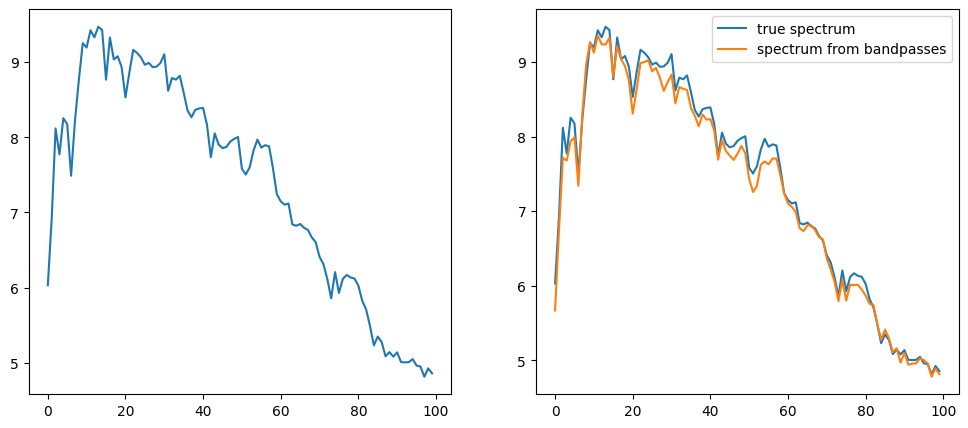

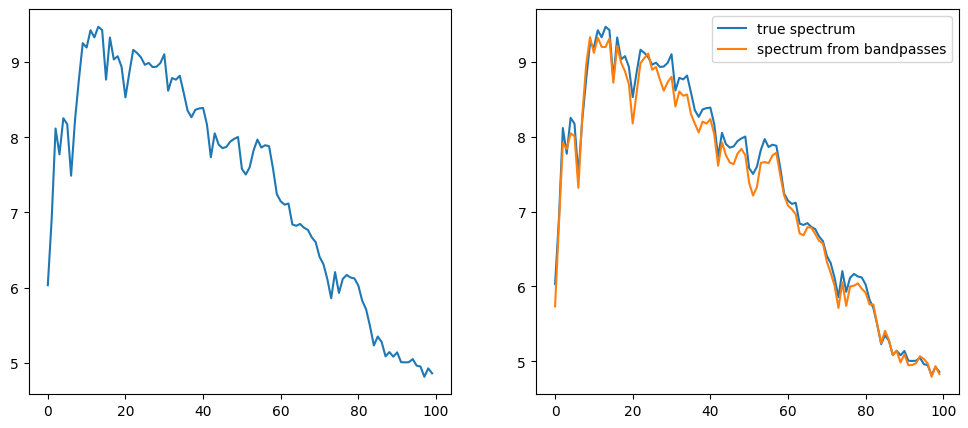

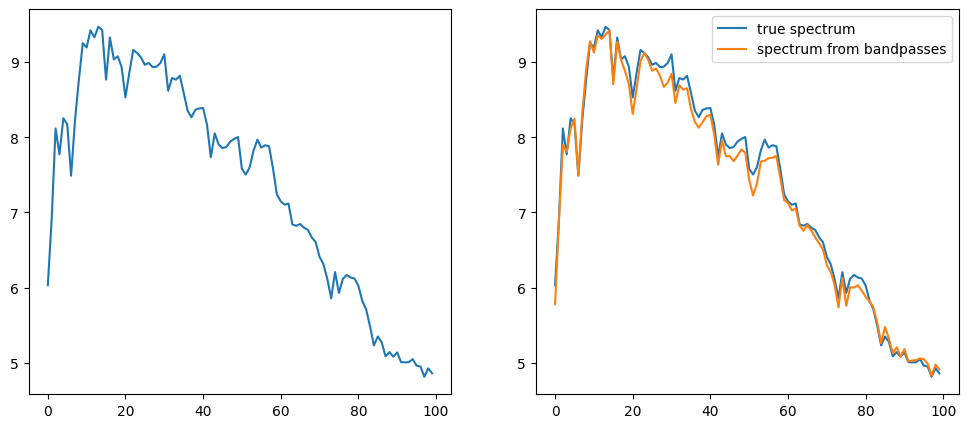

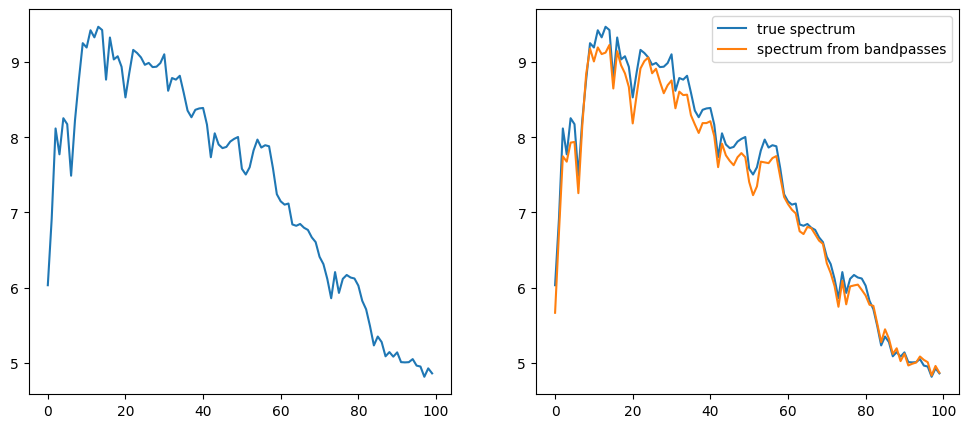

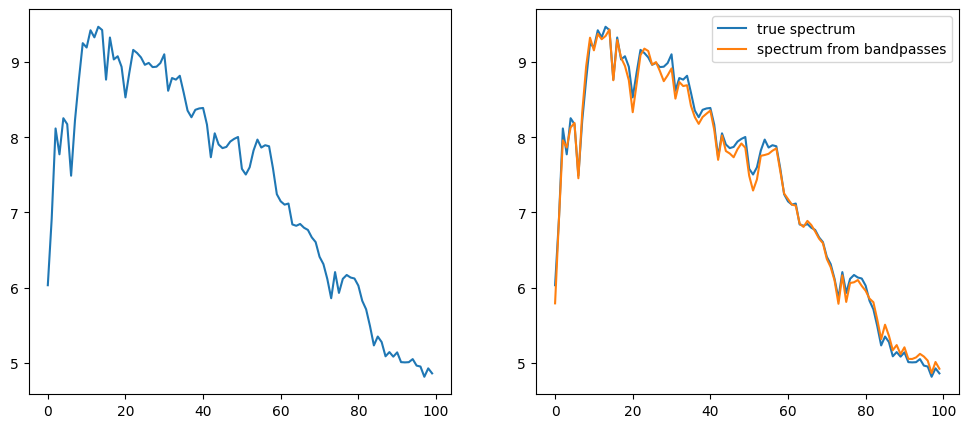

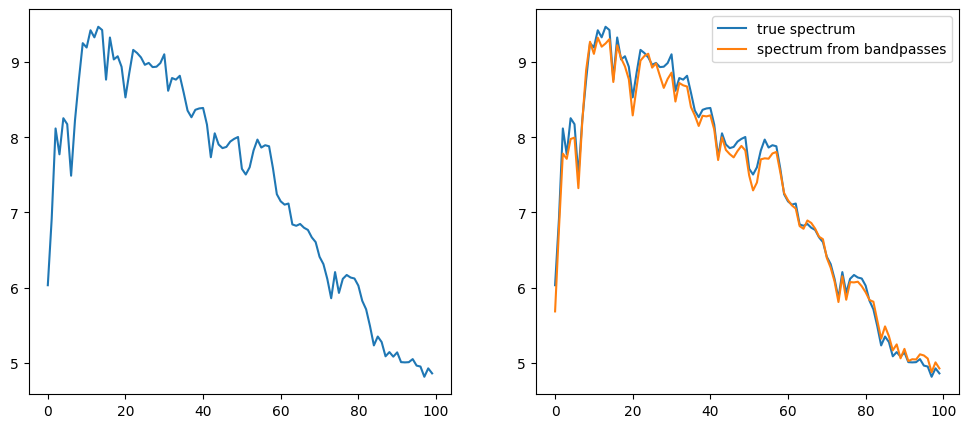

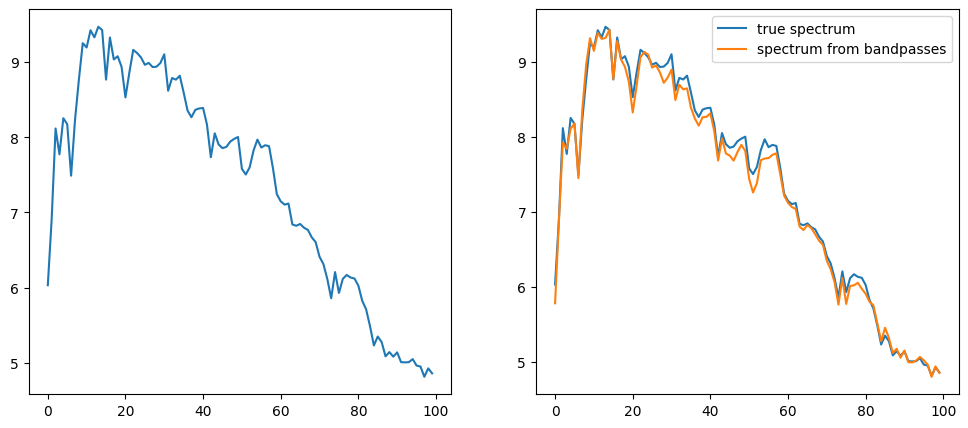

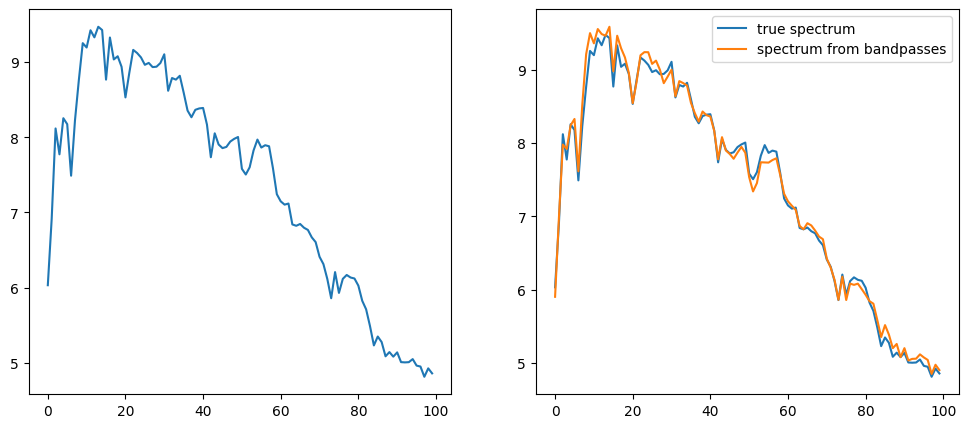

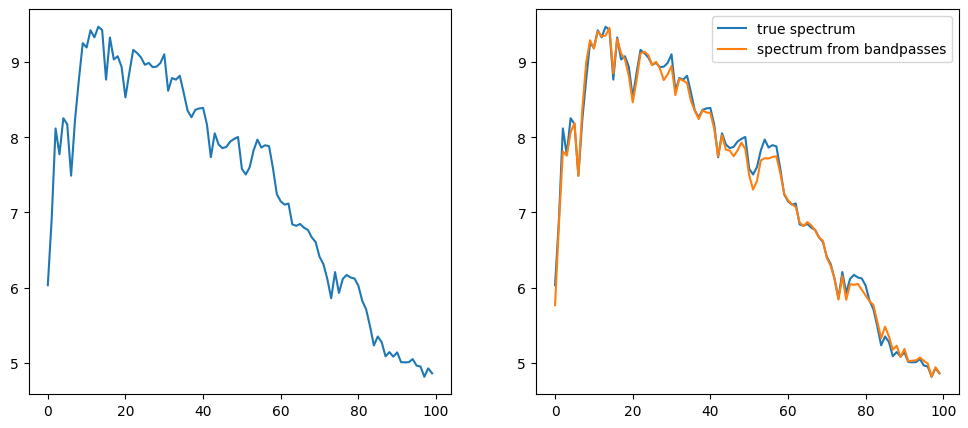

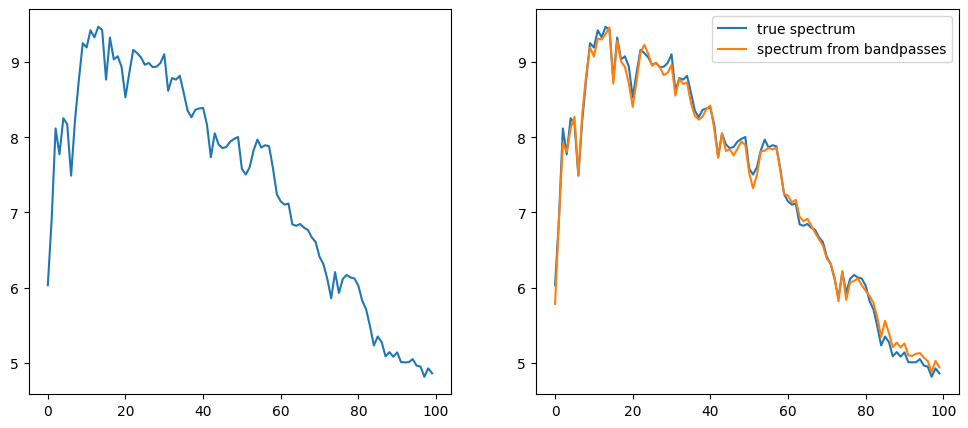

In [96]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()

In [97]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [98]:
bpvae = BandPassVAE(5,16, beta=0.0001)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_207']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


714/720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 76.0309 - loss: 0.3888 - reconstruction_loss: 0.3812((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 100) dtype=float32>),)
720/720 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - kl_loss: 76.1296 - loss: 0.3857 - reconstruction_loss: 0.3780 - val_kl_loss: 32.4575 - val_loss: 0.2706 - val_reconstruction_loss: 0.2673
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 93.9641 - loss: 0.0480 - reconstruction_loss: 0.0386 - val_kl_loss: 37.4146 - val_loss: 0.1867 - val_reconstruction_loss: 0.1830
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 88.7068 - loss: 0.0297 - reconstruction_loss: 0.0208 - val_kl_loss: 41.4765 - val_loss: 0.1384 - val_reconstruction_loss: 0.1343
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 84.6271 - loss: 0.0236 - reconstruction_loss: 0.0151 - val_kl_loss: 41.3474 - val_loss: 0.1365 - val_reconstruction_loss: 0.1324
Epoch 5/10
720/720 ━━━━━━━━━━

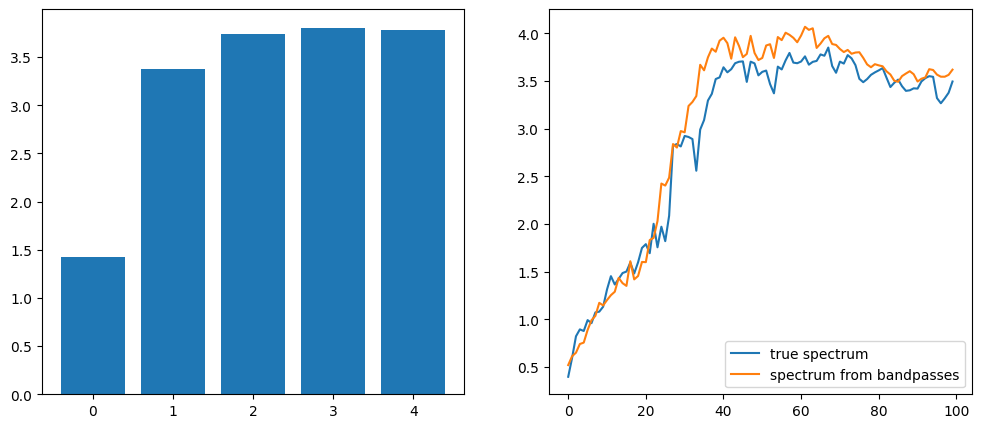

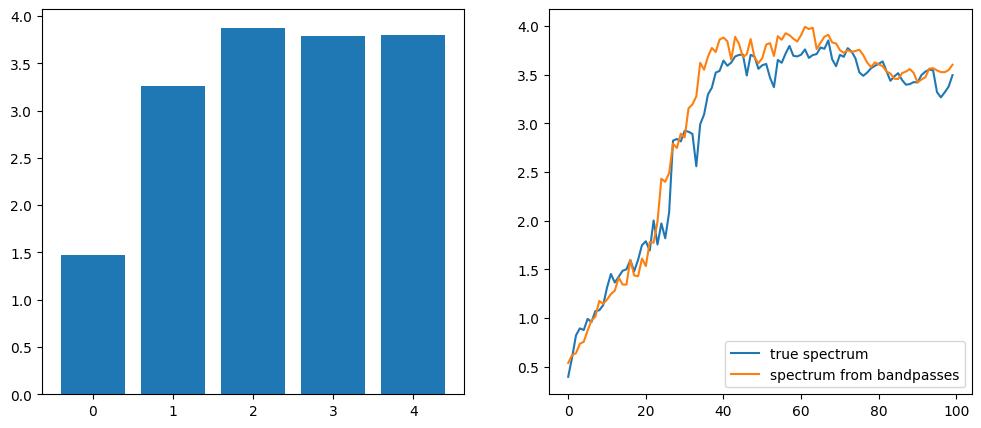

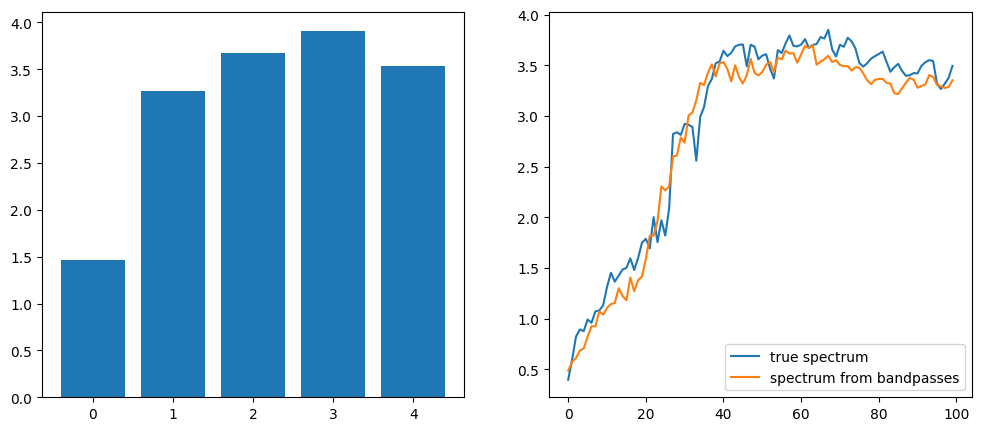

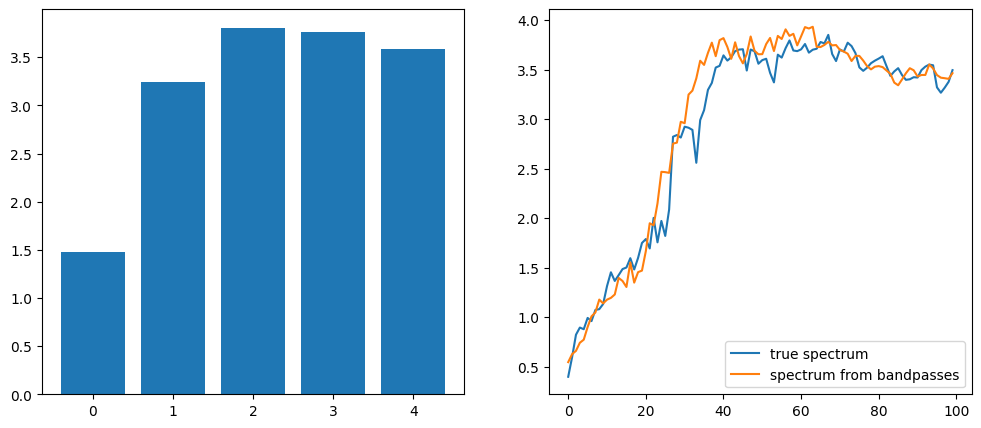

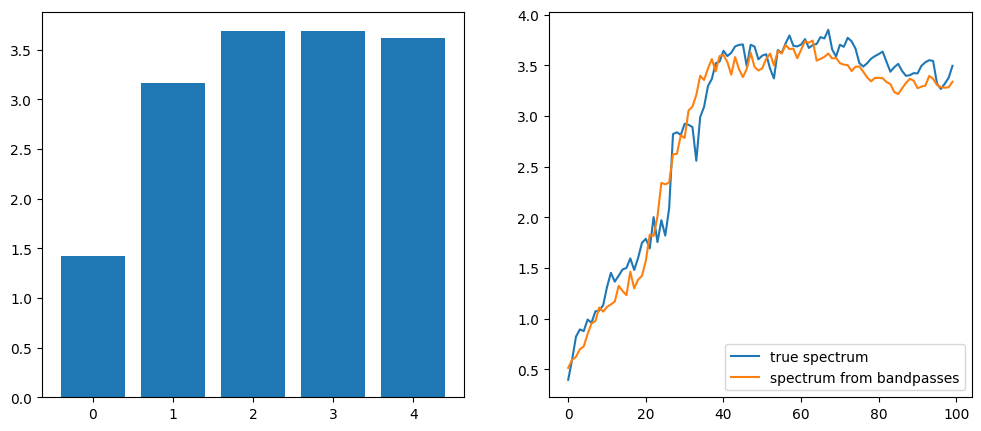

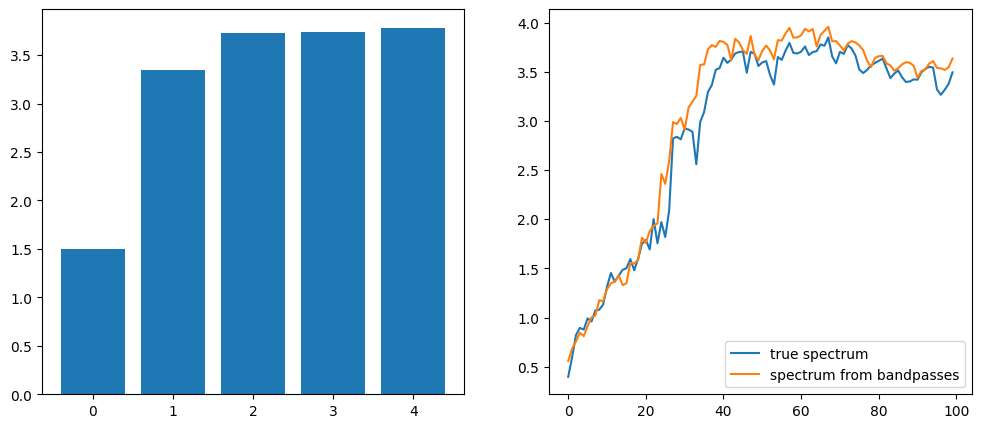

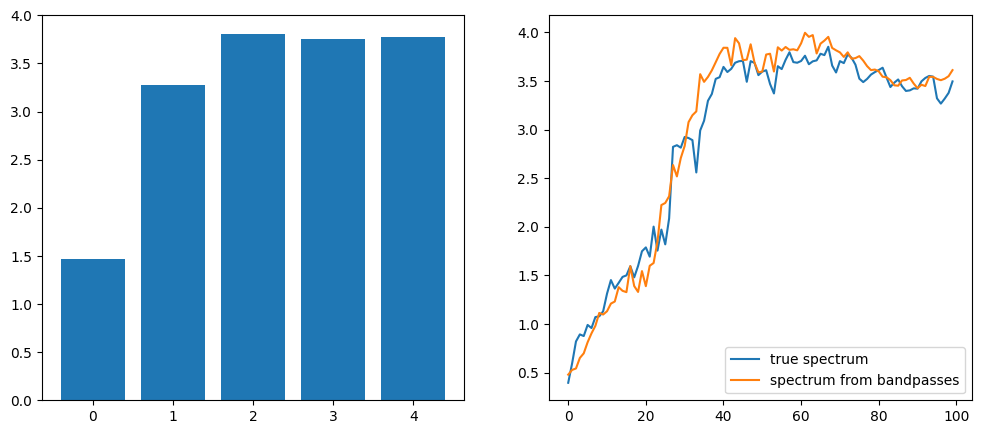

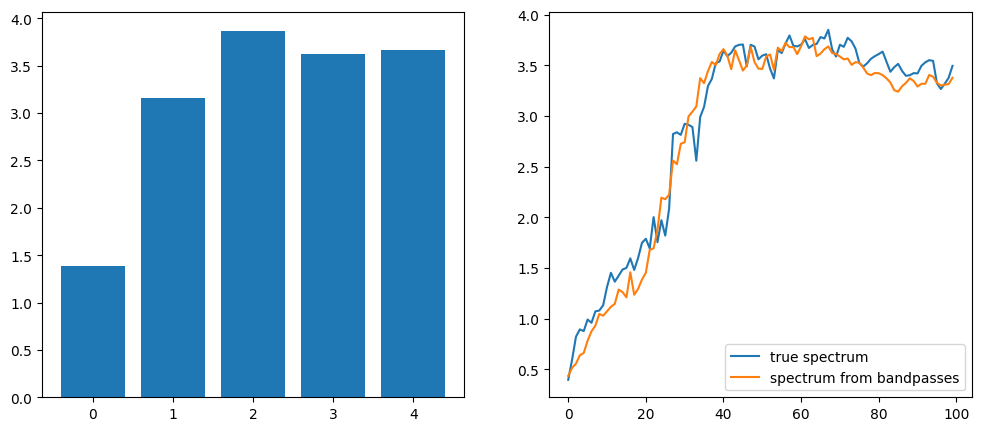

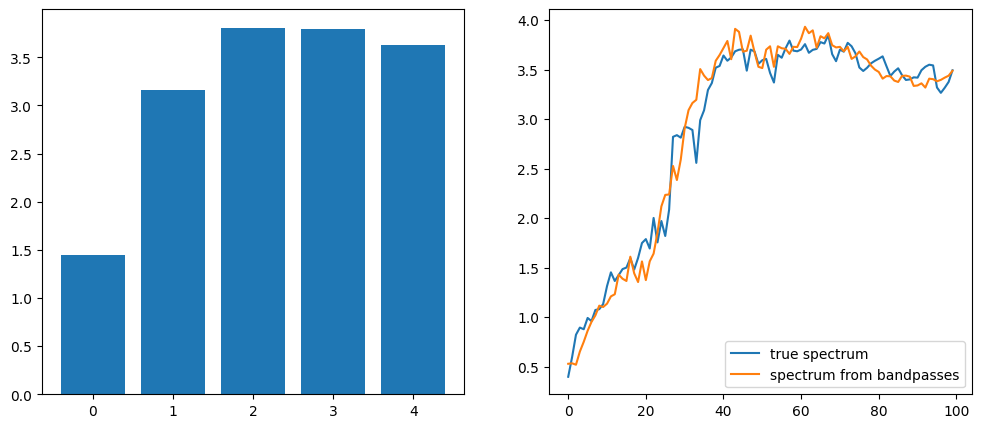

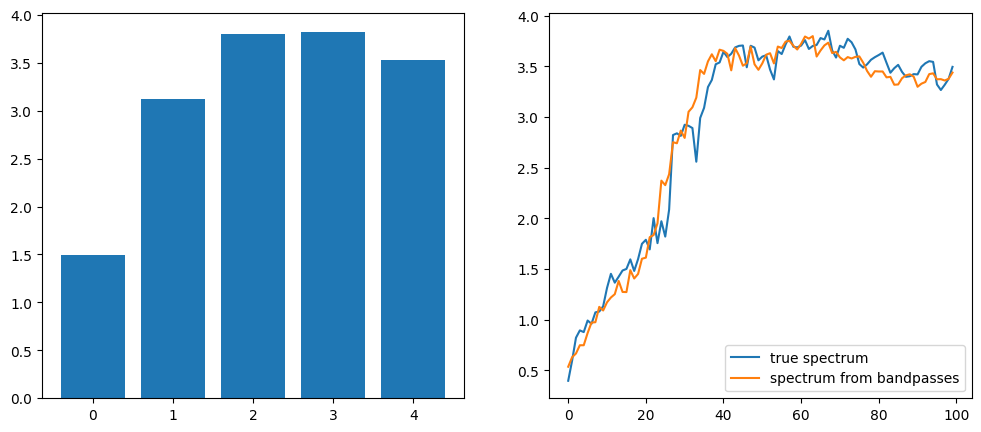

In [100]:
ii=50126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].bar(range(len(integrals[ii])), integrals[ii])
    plt.legend()
    plt.show()

In [105]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(3,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out - reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out - reconstruction))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [109]:
print(params[0])

parvae = ParamVAE(3,16, beta=0.0001)
parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((integrals, params), epochs=10, batch_size=128, validation_split=0.2)

[0.  0.1 0. ]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_168/kernel', 'dense_168/bias', 'dense_169/kernel', 'dense_169/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 64.1396 - loss: 0.3019 - reconstruction_loss: 0.2955((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 3) dtype=float32>),)
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - kl_loss: 64.1500 - loss: 0.3003 - reconstruction_loss: 0.2939 - val_kl_loss: 46.4840 - val_loss: 1.4651 - val_reconstruction_loss: 1.4604
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 64.1486 - loss: 0.0671 - reconstruction_loss: 0.0606 - val_kl_loss: 46.4840 - val_loss: 1.2418 - val_reconstruction_loss: 1.2371
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 64.1330 - loss: 0.0588 - reconstruction_loss: 0.0523 - val_kl_loss: 46.4840 - val_loss: 1.1520 - val_reconstruction_loss: 1.1473
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 64.1462 - loss: 0.0559 - reconstruction_loss: 0.0495 - val_kl_loss: 46.4840 - val_loss: 1.2996 - val_reconstruction_loss: 1.2950
Epoch 5/10
720/720 ━━━━━━━━━━━━

tf.Tensor([ 0.06065371  0.1678028  -0.24785602], shape=(3,), dtype=float32) [0.  0.1 0. ]


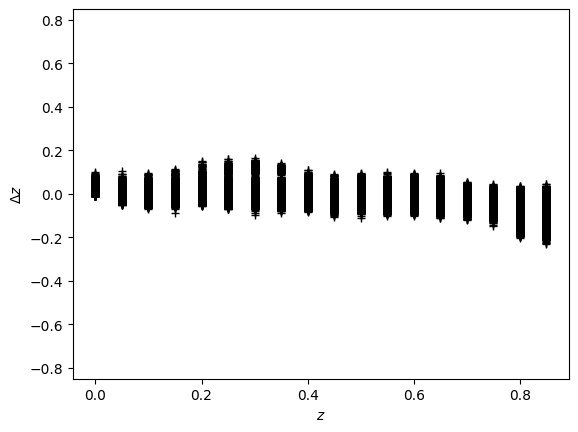

In [120]:
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(integrals[:100000], (100000,5)))
p = params[:100000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]] / 10.0
ply = res[:, axs[1]] / 10.0
plt.plot(plx, ply, 'k+')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
